<a href="https://colab.research.google.com/github/himawanbayu/nlp-team-3/blob/main/take_a_look_at_SciQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Analysis of SciQ Training Set
**This notebook only focuses on the training set**  
Outline:
1. Setup & Data Loading
2. Data Strucutre
3. Length Analysis  
  min., max., avg., sd  
4. Keyword using TF-IDF
5. Readability using Flesch-Kincaid Grade Level
6. Domain Classification
7. Semantic Similarity using Scibert Uncased
8. Question Type

## 1. Setup & Data Loading

In [ ]:
!pip install datasets
!pip install scikit_learn
!pip install textstat

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import textstat
from transformers import AutoTokenizer, AutoModel
import torch
import re
from collections import Counter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 42.8 MB/s eta 0:00:00


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
ds = load_dataset("allenai/sciq")
train_data = ds["train"]

# Convert to pandas df
train_df = pd.DataFrame(train_data)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.02k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.99M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/339k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/343k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11679 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

## 2. Data Strucutre

In [ ]:
# Basic dataset info
print(f"Dataset size: {len(train_df)} records")
print(f"Columns: {train_df.columns}")

# Check for missing values
print("Missing values per column")
print(train_df.isnull().sum())

# Sample
print("\nSample record:")
display(train_df.iloc[0])


Dataset size: 11679 records
Columns: Index(['question', 'distractor3', 'distractor1', 'distractor2',
       'correct_answer', 'support'],
      dtype='object')
Missing values per column
question          0
distractor3       0
distractor1       0
distractor2       0
correct_answer    0
support           0
dtype: int64

Sample record:


,0
question,What type of organism is commonly used in prep...
distractor3,viruses
distractor1,protozoa
distractor2,gymnosperms
correct_answer,mesophilic organisms
support,"Mesophiles grow best in moderate temperature, ..."


To simplify the reusable analysis, the components are defined in a dictionary.

In [ ]:
components = {
    'question': train_df['question'],
    'correct_answer': train_df['correct_answer'],
    'distractor1': train_df['distractor1'],
    'distractor2': train_df['distractor2'],
    'distractor3': train_df['distractor3'],
    'support': train_df['support'] # The context of each question
}

# Group all distractors for some analysis
all_distractors = pd.concat([
    pd.Series(train_df['distractor1']),
    pd.Series(train_df['distractor2']),
    pd.Series(train_df['distractor3']),
]).reset_index(drop=True)

## 3. Length Analysis
Length analysis will be conducted at both character and token levels.   
The statistic results include: mean, median, min, max, std, and raw data.  
The lengths between correct answers and disctractors are compared to identify possible patterns.



In [ ]:
def analyse_length(text_series):
  # Char length
  char_lengths = text_series.str.len()

  # Token length (word count)
  token_lengths = text_series.apply(lambda x: len(word_tokenize(x)))

  results = {
      'char_length': {
          'mean': char_lengths.mean(),
          'median': char_lengths.median(),
          'min': char_lengths.min(),
          'max': char_lengths.max(),
          'std': char_lengths.std(),
          'raw_data': char_lengths
      },
      'token_length': {
          'mean': token_lengths.mean(),
          'median': token_lengths.median(),
          'min': token_lengths.min(),
          'max': token_lengths.max(),
          'std': token_lengths.std(),
          'raw_data': token_lengths
      }

  }
  return results

In [ ]:
# Apply length analysis to all components
length_results = {component: analyse_length(data) for component, data in components.items()}

# Compare correct answers and distractors
correct_lengths = length_results['correct_answer']['token_length']['raw_data']
distractor_lengths = all_distractors.apply(lambda x: len(word_tokenize(x)))

Visualisation of length distribution


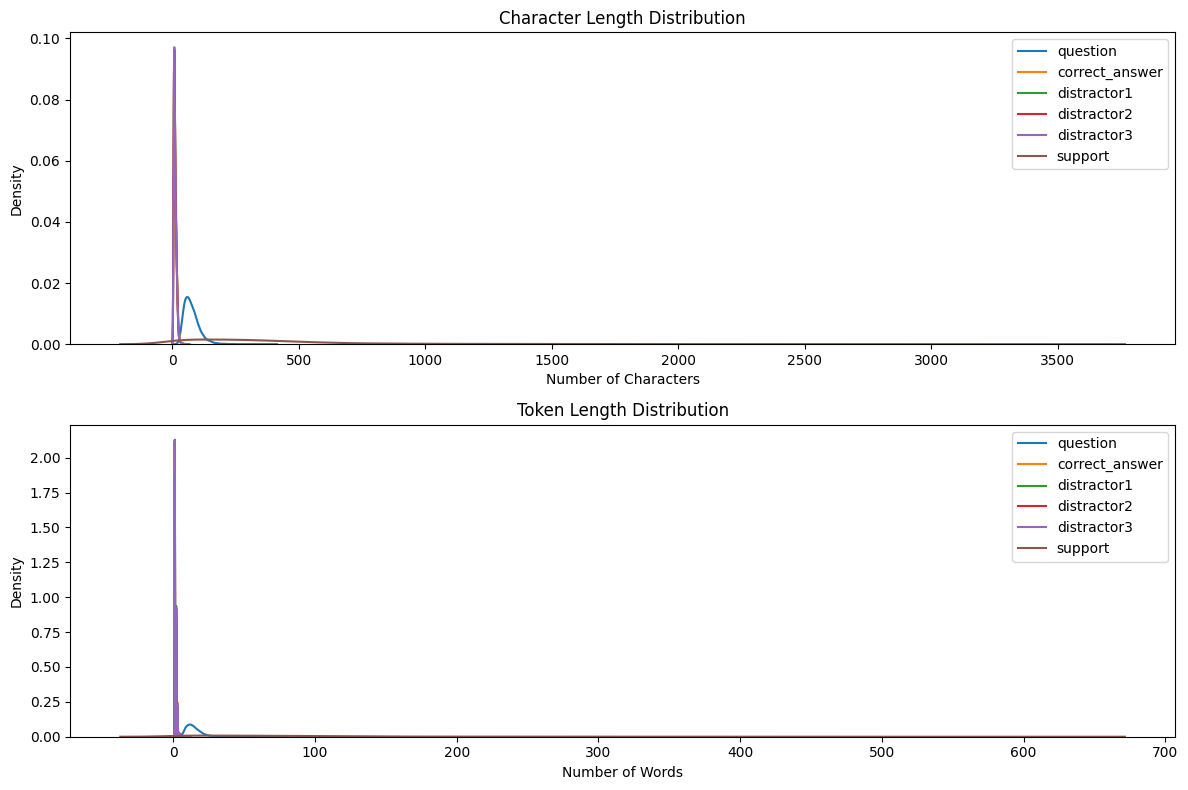

<ipython-input-20-c07d006dd71c>:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_lengths, distractor_lengths], labels = ['Correct Answers', 'Distractors'])


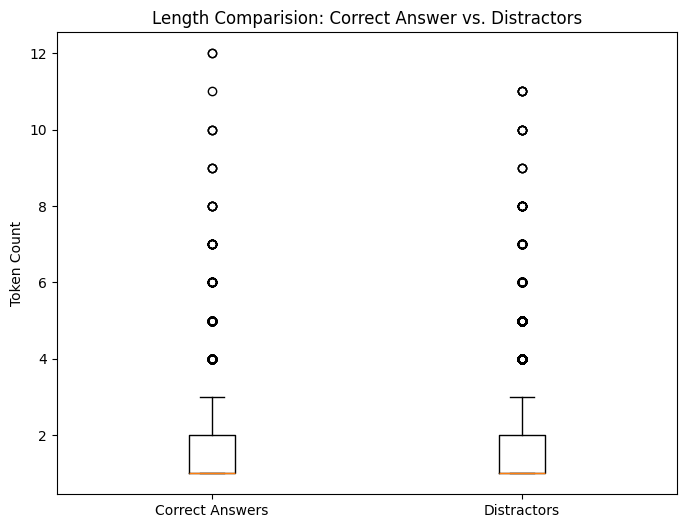

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
for component, result in length_results.items():
  sns.kdeplot(result['char_length']['raw_data'], label = component)
plt.xlabel('Number of Characters')
plt.title('Character Length Distribution')
plt.legend()

plt.subplot(2, 1, 2)
for component, result in length_results.items():
  sns.kdeplot(result['token_length']['raw_data'], label = component)
plt.xlabel('Number of Words')
plt.title('Token Length Distribution')
plt.legend()
plt.tight_layout()
plt.show()

# Comparision between correct answer and distractors
plt.figure(figsize=(8, 6))
plt.boxplot([correct_lengths, distractor_lengths], labels = ['Correct Answers', 'Distractors'])
plt.title('Length Comparision: Correct Answer vs. Distractors')
plt.ylabel('Token Count')
plt.show()

**The two graphs have scle issues, the support texts are too long, compressing other components on the very left side.**   
Support texts: widely variable length, to 3.5k+ characters.  
Questions: around 50 - 200 charcters.  
Answer options: less than 50 char, making sense.  


## 4. Keyword Analysis using TF-IDF

In [ ]:
def extract_keywords(text_series, n_keywords=10):
  # Initialise top keywords using tfidf
  tfidf = TfidfVectorizer(
      max_features = 2000, # dataset not very big
      stop_words = 'english',
      ngram_range=(1, 2) # Capture more semantic info
  )

  # Fit and transform the text
  tfidf_matrix = tfidf.fit_transform(text_series)

  # Get feature names
  feature_names = tfidf.get_feature_names_out()

  # Calculate mean TF-IDF score for each term
  mean_tfidf = np.mean(tfidf_matrix.toarray(), axis=0)

  # Get top keywords
  top_indices = mean_tfidf.argsort()[-n_keywords:][::-1]
  top_keywords = [(feature_names[i], mean_tfidf[i]) for i in top_indices]

  return top_keywords

In [ ]:
keyword_results = {component: extract_keywords(data) for component, data in components.items()}
# first column: keyword; second column: score


Visualisation

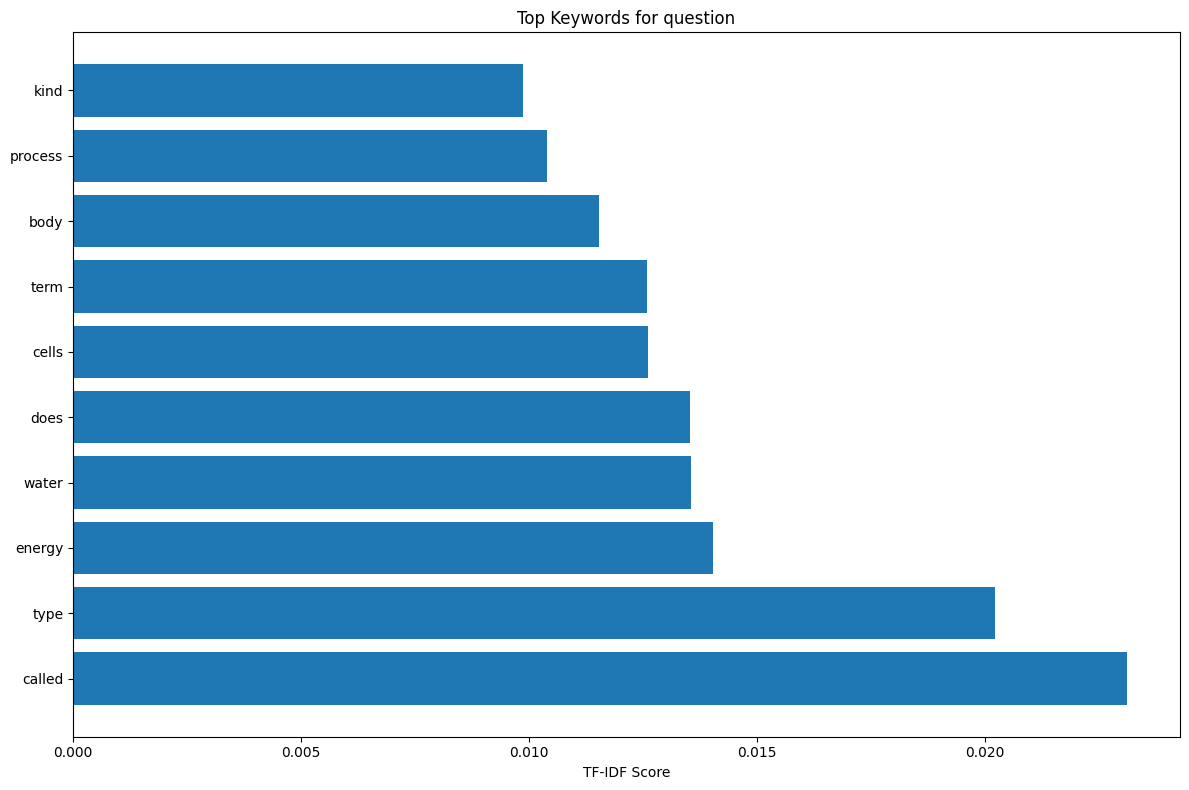

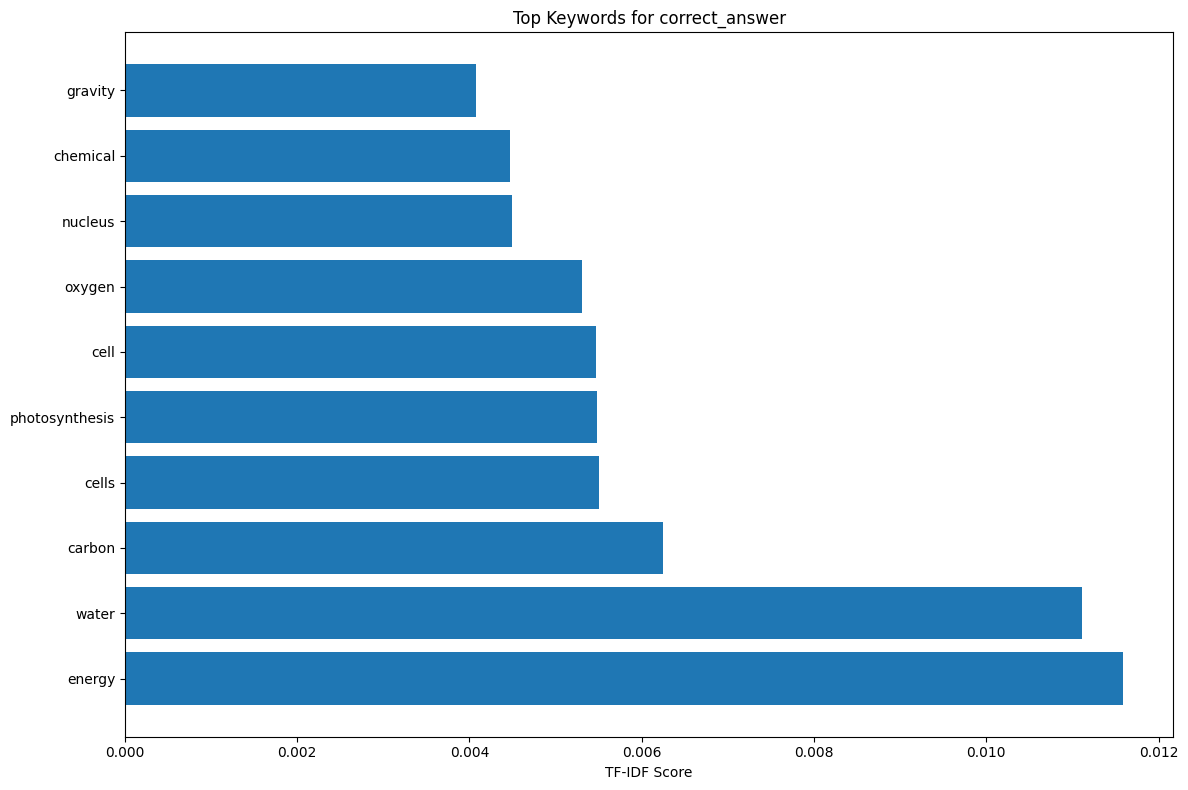

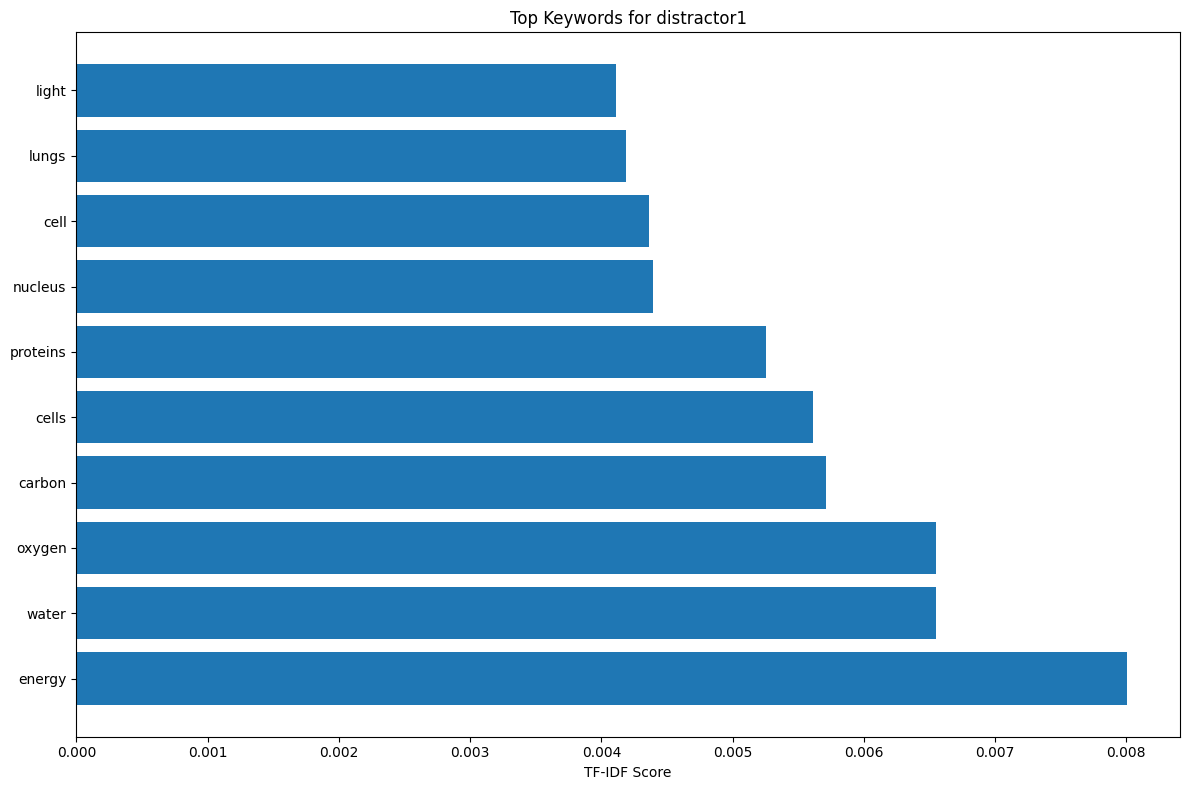

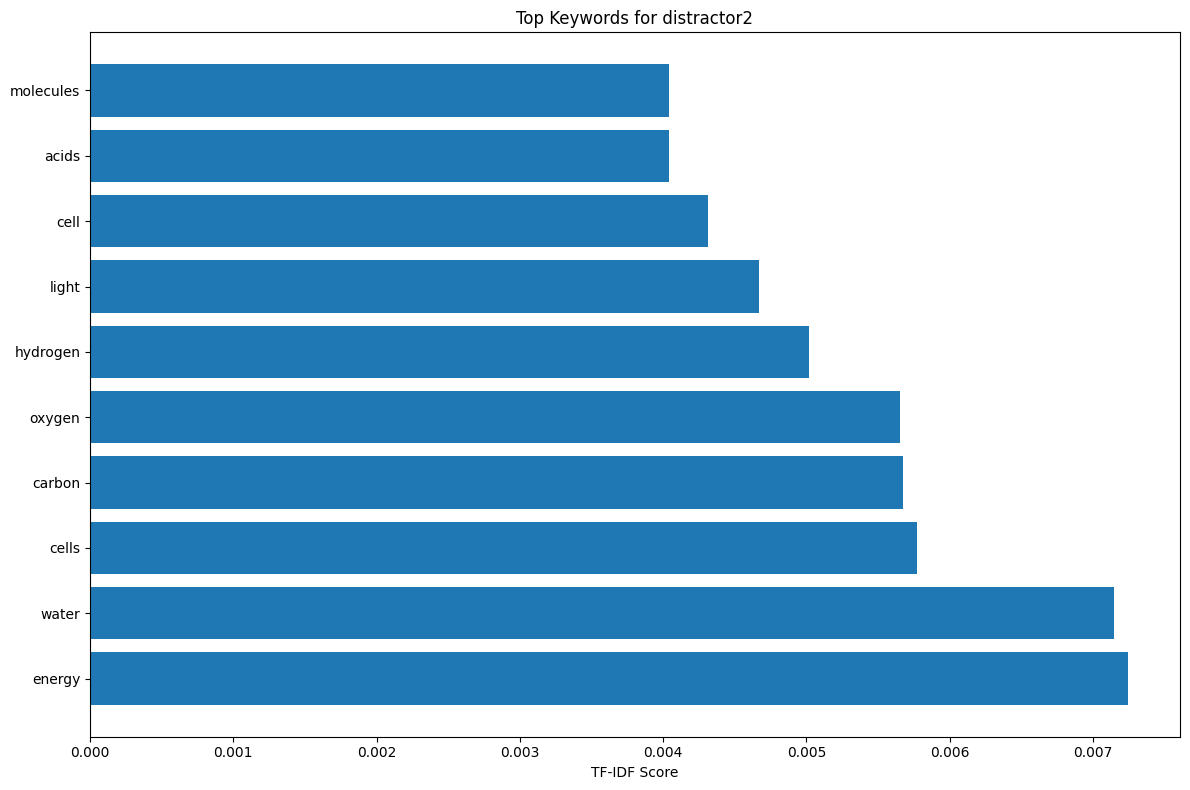

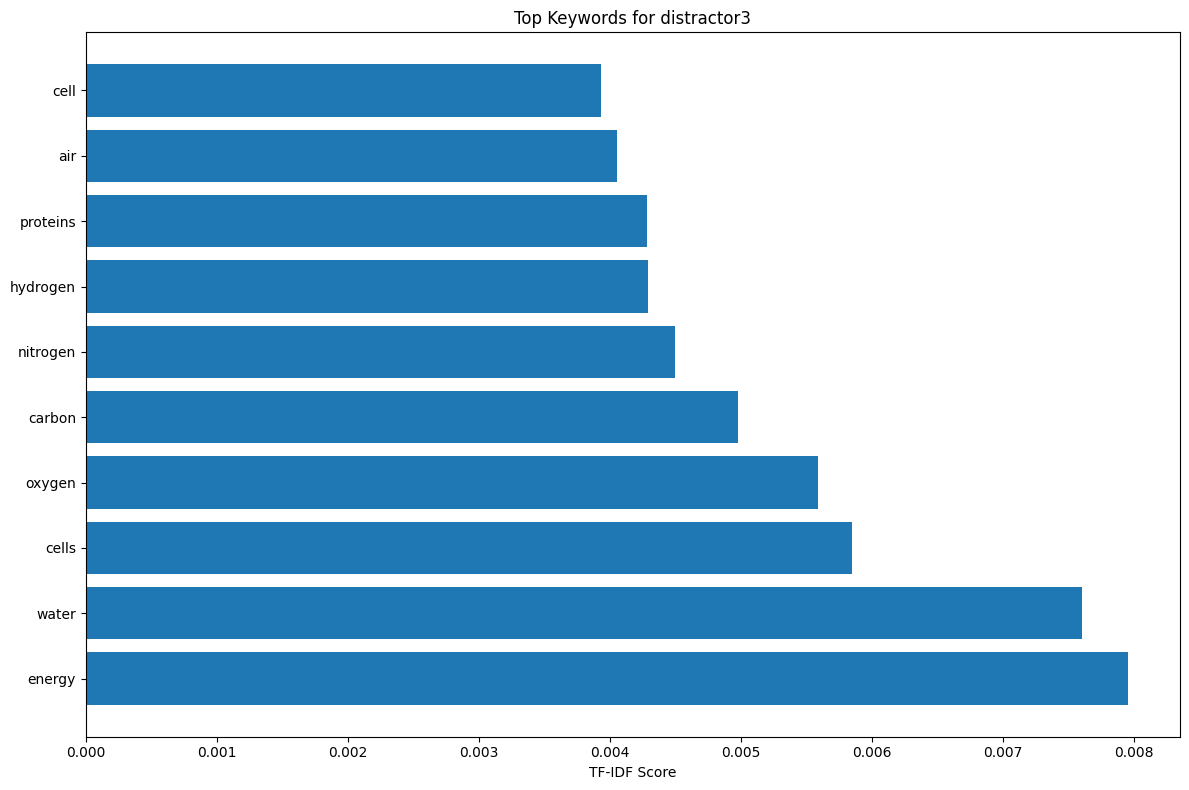

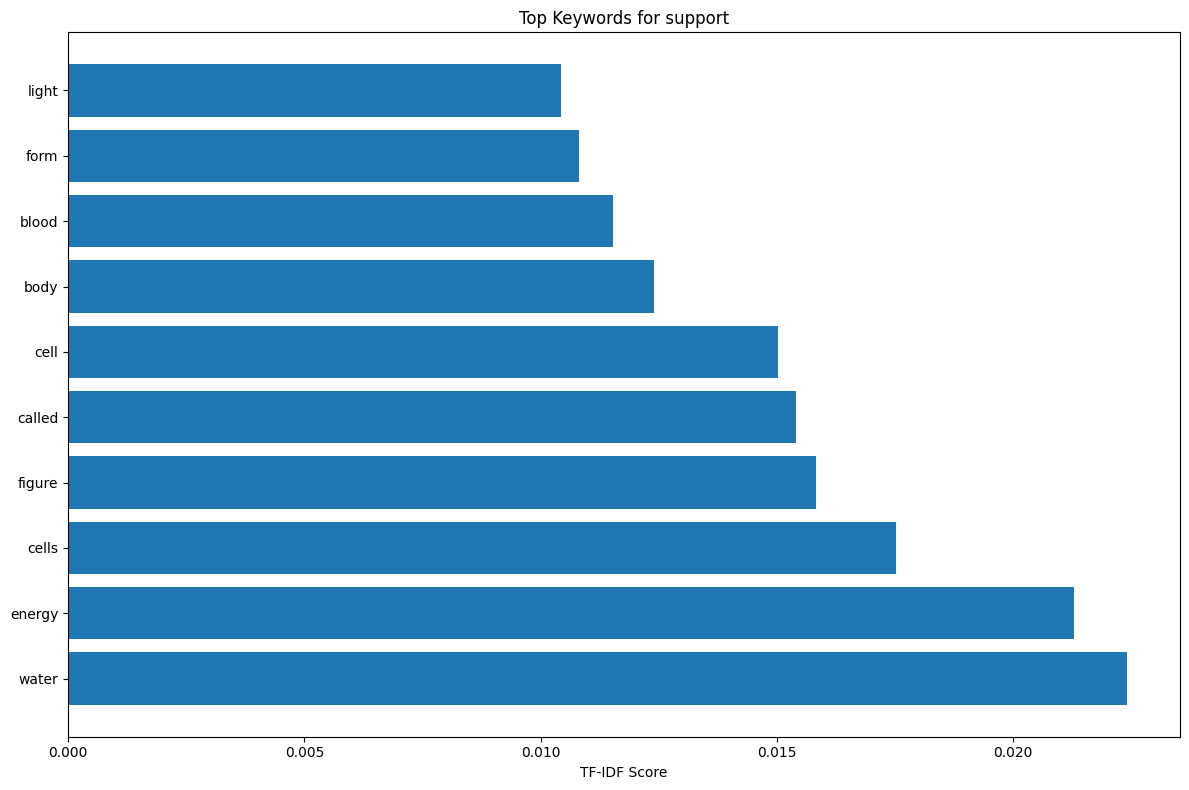

In [ ]:
for component, keywords in keyword_results.items():
  plt.figure(figsize=(12, 8))
  terms = [kw[0] for kw in keywords]
  scores = [kw[1] for kw in keywords]

  plt.barh(terms, scores)
  plt.title(f'Top Keywords for {component}')
  plt.xlabel('TF-IDF Score')
  plt.tight_layout()
  plt.show()

The keywords list shows some typical Q & A features.  
Questions include `called` and `does`, while answer options are mostly noun (phrases).

## Readability Analysis
Among multiple metrics for measuring readability, I chose Flesch-Kincaid Grade Level because:
1. It is one of the most frequently used for measuring English readability, and
2. It indicates US school level (from 5th grade to professional) as a directy analogy.  

The function is based on the library `textstat`.

In [ ]:
def calculate_readability(text_series):
  fk_scores = text_series.apply(lambda x: textstat.flesch_kincaid_grade(x))

  results = {
      'mean': fk_scores.mean(),
      'median': fk_scores.median(),
      'min': fk_scores.min(),
      'max': fk_scores.max(),
      'std': fk_scores.std(),
      'raw_scores': fk_scores.values
  }

  return results

In [ ]:
readability_results = {component: calculate_readability(data) for component, data in components.items()}

print(readability_results)

{'question': {'mean': 8.122921483003683, 'median': 8.0, 'min': -2.3, 'max': 28.1, 'std': 3.5939218865154103, 'raw_scores': array([ 9.5, 13.8,  7.2, ..., 13.5,  8. ,  8.3])}, 'correct_answer': {'mean': 14.276607586265948, 'median': 9.2, 'min': -3.5, 'max': 67.4, 'std': 12.929439070981804, 'raw_scores': array([14.7, 14.7, 32. , ...,  8.4, 32. ,  8.4])}, 'distractor1': {'mean': 13.420609641236409, 'median': 8.8, 'min': -15.7, 'max': 67.4, 'std': 12.328982785078985, 'raw_scores': array([32. ,  2.9, 20.2, ...,  8.4, -3.1, -3.5])}, 'distractor2': {'mean': 13.499751691069442, 'median': 8.8, 'min': -3.5, 'max': 67.4, 'std': 12.494997078227614, 'raw_scores': array([ 8.4, 20.6, 20.2, ..., -3.5,  2.9,  8.4])}, 'distractor3': {'mean': 13.444190427262608, 'median': 8.8, 'min': -3.5, 'max': 67.4, 'std': 12.34484874649176, 'raw_scores': array([20.2, 14.7, 32. , ...,  8.4, 20.2,  8.4])}, 'support': {'mean': 6.883226303621886, 'median': 8.9, 'min': -15.7, 'max': 100.0, 'std': 8.175525319625029, 'raw_sc

Visulasation

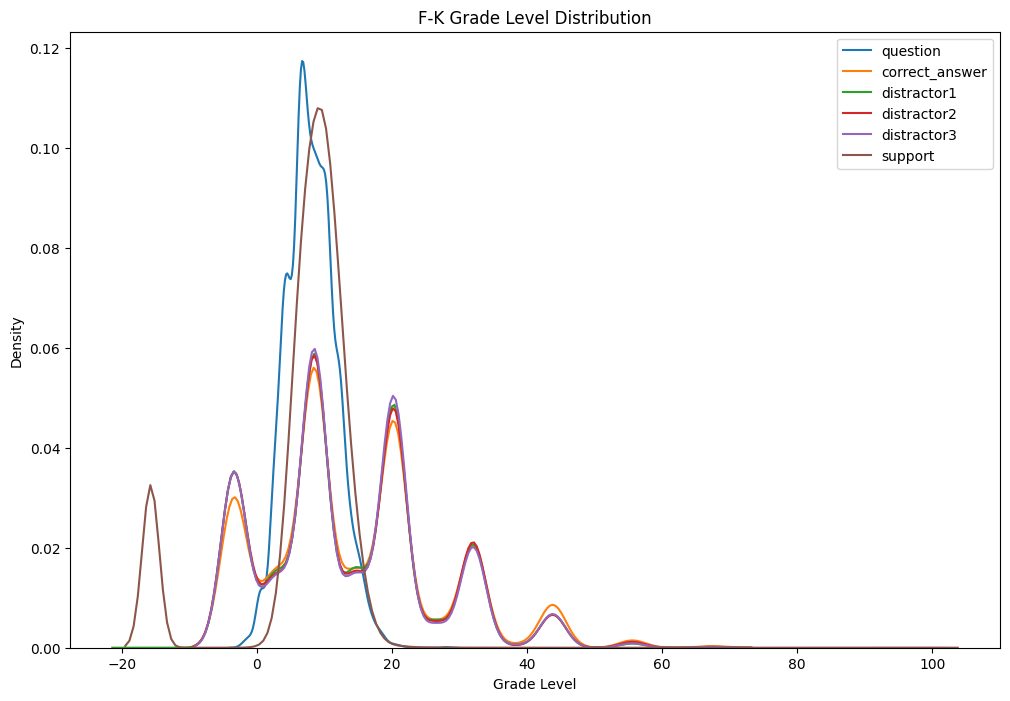

In [ ]:
plt.figure(figsize=(12, 8))
for component, result in readability_results.items():
  sns.kdeplot(result['raw_scores'], label= component)
plt.title('F-K Grade Level Distribution')
plt.xlabel('Grade Level')
plt.legend()
plt.show()

**The unusual, multi-spike graph suggests that F-K score may not be the best for measuring readability for this type of text.**
However, there are still some key points worthy of notice:
1. The multiple peaks, rather than normal bell curves, suggest the dataset contains distinct categories of text with different complexity levels -- biology/physics/chemistry ~ formula/bullet points/etc.
2. F - K score can be from negative to positive extremely high, though uncommon. The negative scores appear for very short texts. Those 40+ super high scores likely represent texts with complex terminology and/or unusual structure (again, formulas and other stuff)
3. The matching pattern between correct answers and distractors means **well-designed answer options**.
4. The highest peaks appear around scores 5 - 10, which means the compoenents are around middle school to college level. A subtle tendency is the questions tend to be easier (making sense), while the support texts being bit harder.

## 6. Domain Classification
It is a very drafty one, only using some rule-based keywords matching.  
But the results can still be used as a reference.

In [ ]:
# Some words would be used by differnt subjects, be aware
science_domains = {
    'physics': ['force', 'energy', 'motion', 'gravity', 'mass', 'velocity', 'acceleration', 'electricity', 'magnetism', 'wave', 'quantum', 'atom', 'particle'],
    'chemistry': ['element', 'compound', 'molecule', 'reaction', 'acid', 'base', 'solution', 'bond', 'electron', 'ion', 'pH', 'organic', 'chemical'],
    'biology': ['cell', 'organism', 'species', 'evolution', 'gene', 'protein', 'tissue', 'bacteria', 'virus', 'enzyme', 'DNA', 'RNA', 'ecosystem', "blood", "proteins"]
} # The word lits are generated by Claude

def classify_domain(text):
    text = text.lower()
    scores = {}

    for domain, keywords in science_domains.items():
        score = sum(1 for keyword in keywords if keyword in text)
        scores[domain] = score

    # Return the domain with the highest score or 'unknown' if all scores are 0
    max_domain = max(scores, key=scores.get)
    return max_domain if scores[max_domain] > 0 else 'unknown'



In [ ]:
# Classify questions and support text
train_df['question_domain'] = train_df['question'].apply(classify_domain)
train_df['support_domain'] = train_df['support'].apply(classify_domain)



Vis

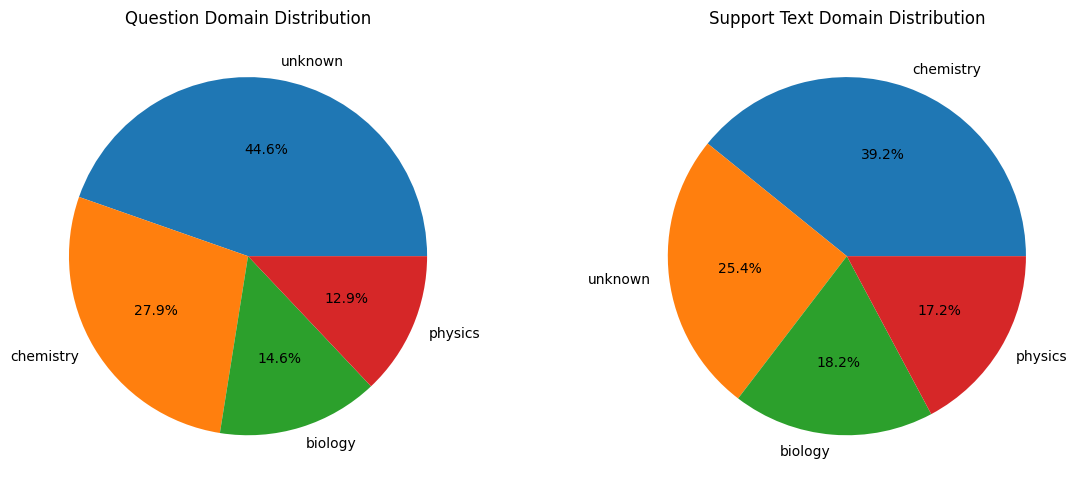

In [ ]:

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
question_domain_counts = train_df['question_domain'].value_counts()
plt.pie(question_domain_counts, labels=question_domain_counts.index, autopct='%1.1f%%')
plt.title('Question Domain Distribution')

plt.subplot(1, 2, 2)
support_domain_counts = train_df['support_domain'].value_counts()
plt.pie(support_domain_counts, labels=support_domain_counts.index, autopct='%1.1f%%')
plt.title('Support Text Domain Distribution')
plt.tight_layout()
plt.show()

## 7. Semantic Similarity Analysis
I use  [SciBERT](https://huggingface.co/allenai/scibert_scivocab_uncased), also from Allen AI, for calculating sentiment similarity. This model is trained on scientic text and so a good fit.  
Assisted by Claude.

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

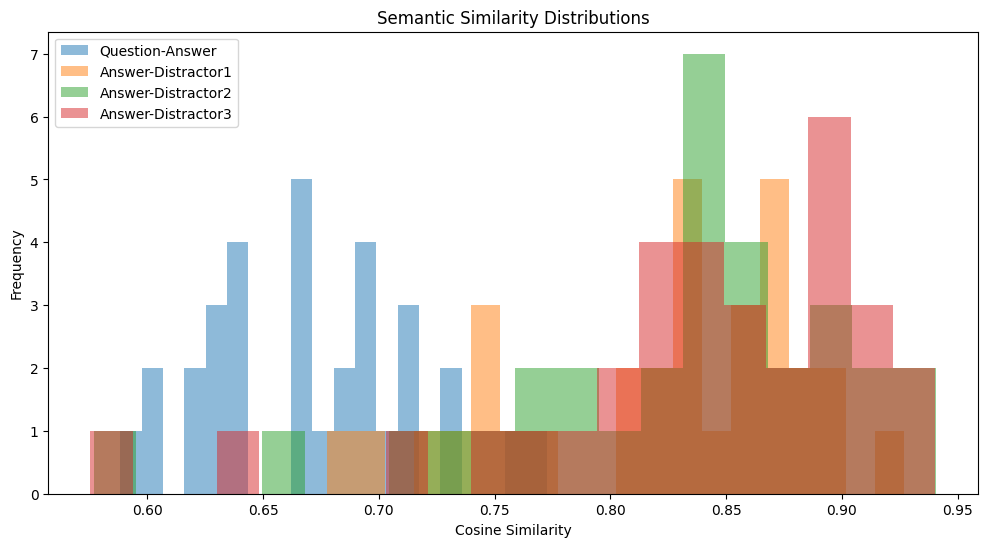

In [ ]:
# load the model and tokeniser
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
model = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased") # I used the uncased one

def get_embeddings(texts, batch_size = 32):
  embeddings = []

  for i in range(0, len(texts), batch_size):
    batch = texts[i:i+batch_size]
    inputs = tokenizer(batch,
                      padding = True,
                      truncation = True,
                      return_tensors = 'pt',
                      max_length = 512)

    with torch.no_grad():
      outputs = model(**inputs)

      # Use CLS token embeddings as sentence representation
      batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
      embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

def calculate_similarity(embeddings1, embeddings2):
    # Normalise embeddings
    norm1 = np.linalg.norm(embeddings1, axis=1, keepdims=True)
    norm2 = np.linalg.norm(embeddings2, axis=1, keepdims=True)

    normalized1 = embeddings1 / norm1
    normalized2 = embeddings2 / norm2

    # Calculate cosine similarity
    similarity = np.sum(normalized1 * normalized2, axis=1)
    return similarity

# Sample a subset for semantic analysis (to keep computation manageable)
sample_size = 500  # Adjust based on computational resources
sample_df = train_df.sample(sample_size, random_state=42)

# Get embeddings
question_embeddings = get_embeddings(sample_df['question'].tolist())
answer_embeddings = get_embeddings(sample_df['correct_answer'].tolist())
distractor1_embeddings = get_embeddings(sample_df['distractor1'].tolist())
distractor2_embeddings = get_embeddings(sample_df['distractor2'].tolist())
distractor3_embeddings = get_embeddings(sample_df['distractor3'].tolist())

# Calculate similarities
question_answer_sim = calculate_similarity(question_embeddings, answer_embeddings)
answer_distractor1_sim = calculate_similarity(answer_embeddings, distractor1_embeddings)
answer_distractor2_sim = calculate_similarity(answer_embeddings, distractor2_embeddings)
answer_distractor3_sim = calculate_similarity(answer_embeddings, distractor3_embeddings)

# Visualise similarity distributions
plt.figure(figsize=(12, 6))
plt.hist(question_answer_sim, alpha=0.5, bins=20, label='Question-Answer')
plt.hist(answer_distractor1_sim, alpha=0.5, bins=20, label='Answer-Distractor1')
plt.hist(answer_distractor2_sim, alpha=0.5, bins=20, label='Answer-Distractor2')
plt.hist(answer_distractor3_sim, alpha=0.5, bins=20, label='Answer-Distractor3')
plt.title('Semantic Similarity Distributions')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

The results of semantic similarity show that the dataset is well-designed and of high quality.  
The lowest score received by Q-A pair means the questions are very different from the correct answers, which is the spirit of question answering -- it would be pointless if the answer could be directly found in the question.  
The other three pairs receive much higher scores with their peaks appearing around 0.82 - 0.9. It suggests that all four answer options are quite similar, while not identical (less than 0.95). It can be believed that the distractors will perform effectively.

## 8. Question Type
It's a simple rule-based detection. It calculates what types of questions are more frequenlty seen in the dataset.

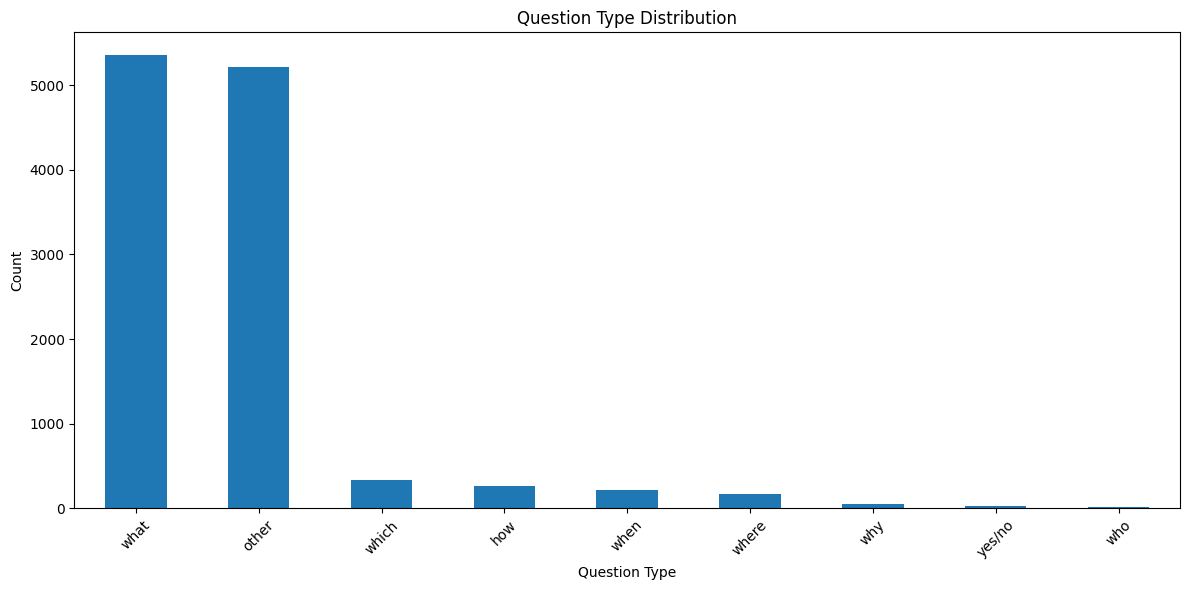

In [ ]:
def categorize_question_type(question):
    """Categorize question based on starting words"""
    question = question.lower().strip()

    # Common question starters
    if question.startswith('what'):
        return 'what'
    elif question.startswith('how'):
        return 'how'
    elif question.startswith('why'):
        return 'why'
    elif question.startswith('when'):
        return 'when'
    elif question.startswith('which'):
        return 'which'
    elif question.startswith('where'):
        return 'where'
    elif question.startswith('who'):
        return 'who'
    elif question.startswith('can') or question.startswith('do') or question.startswith('does'):
        return 'yes/no'
    else:
        return 'other'

# Analyze question types
train_df['question_type'] = train_df['question'].apply(categorize_question_type)
question_type_counts = train_df['question_type'].value_counts()

# Visualize question type distribution
plt.figure(figsize=(12, 6))
question_type_counts.plot(kind='bar')
plt.title('Question Type Distribution')
plt.xlabel('Question Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The highest `what` and `which` adhere to our observation in 4. Keywords.